# Do you want to buy a house?

---
**Author:** Janosch Heinermann & Lukas Bollenbach\
**Course:** Data Analytics\
**Teacher**: Axel Wemmel\
**Date:** 2024-02-02

---

## This is a python script that scrapes real estate data from the web and displays it on a Dashboard.

Load all the modules that we use

In [48]:
import pandas as pd                         # Create DataFrames objects
import numpy as np                          # Create numpy array etc.
import requests                             # Request data from Website (API)
import bs4                                  # Read requested html-data
from datetime import datetime               # Get current time
import time                                 # Get current time (seconds)
import os                                   # Search if file exists
import winsound                             # Make sound if something is finished 
import seaborn as sns                       # Plot of Na-Values
import plotly_express as px                 # Create nice Plots
import json                                 # Work with json data
import dash                                 # Create Dashboard
from dash import dcc, dash_table, html      # Used for Dashboards
import geopandas as gpd                     # Work with geo-data
from dash.dependencies import Input, Output # Input and Output for app.callback
import plotly.graph_objects as go           # avoids figs not plotting at first call https://community.plotly.com/t/valueerror-invalid-value-in-basedatatypes-py/55993
import utm                                  # Convert UTM Coordinates to Web Mercator Coordinates
from shapely.geometry import Polygon, MultiPolygon  # Use Polygons and Mulipolygons for coordinate conversion



Let's now scrape data from immowelt.com. We do this primarily using beautifulsoup (bs4) and requests.\
The general scraping workflow is as follows:
1. Search on immowelt.com using a postal code (Postleitzahl/PLZ)
2. On the first site of search results, get all information of all real estates
3. Go to the next side and see if there are more real estates. If not, scraping for this PLZ is done, if yes, go back to 2.

 There are ~8200 postal codes in Germany. We want to use the postal codes to scrape immowelt.com.\
To avoid losing all data in case of an error, we do batches of 100 postal codes.\
We found all postal codes on a [website](https://public.opendatasoft.com/explore/dataset/georef-germany-postleitzahl/table/)\
\
**Here is the python code:**

```python
# Save real estate data from immowelt.com in csv-files:
ID_Counter = 0

# Import postal codes:
Postleitzahlen = pd.read_csv("PLZ_Germany.csv", sep=";")
PLZ = Postleitzahlen["Postleitzahl / Post code"].unique()
PLZ_Anzahl = len(PLZ)

# There are ~8200 postal codes in Germany. We want to use the postal codes to scrape immowelt.com.
# To avoid losing all data in case of an error, we do batches of 100 postal codes.
numbs = [x * 100 for x in range(0, 82)]
for num1 in numbs:
    num2 = num1 + 99

    # Create an empty DataFrame to 1. save the heading in a csv-file and 2. fill in the following loop.
    immobilien_list = {'HausID': [], 'ImmoID': [], 'PLZ': [], 'Preis': [], 'Fläche': [], 'Zimmer': [],
                    'Grundstücksfläche': [], 'Hausbeschreibung': [], 'url': [], 'timestamp': []}
    immobilien_pd = pd.DataFrame.from_dict(immobilien_list)

    # If there is no file with the current postal code range:
    mypath = "Scraped_Data/Immowelt_Scrape_" + str(num1) + "-" + str(num2) + ".csv"
    if not os.path.isfile(mypath):
        immobilien_pd.to_csv(mypath, index=False)

    start = time.time() # Save the time at the start of the loop
    print("*****************************\n")

    # Now iterate through the current batch of postal codes
    for PLZn, PLZi in enumerate(PLZ[num1:num2]):

        # Create an empty dictionary to save scraped data in
        immobilien_list = {'HausID': [], 'ImmoID': [], 'PLZ': [], 'Preis': [], 'Fläche': [], 'Zimmer': [],
                        'Grundstücksfläche': [], 'Hausbeschreibung': [], 'url': [], 'timestamp': []}

        # Postal codes are loaded as int and thus, all leading 0 are deleted. This transforms it into a str and add leading 0 if nessecary
        if PLZi < 10000:
            PLZi = '0' + str(PLZi)
        else:
            PLZi = str(PLZi)

        # Print the current state of the loop
        print(f'Looking for PLZ: {PLZi}. Number {PLZn + 1} of {PLZ_Anzahl}. ({((PLZn + 1) / PLZ_Anzahl * 100):.2f} %)', end="\r")

        # Reset variables
        pagei = 1       # Reset the current search-page to 1
        nHouses = -1    # Reset the number of houses on a page to -1

        # Iterate through all pages until there are no more houses on a page (nHouses = 0)
        while nHouses != 0:

            # Get data from the current page
            url = "https://www.immowelt.de/suche/" + str(PLZi) + "/haeuser/kaufen?d=true&sp=" + str(pagei)
            response = requests.get(url)
            html = response.content.decode("UTF-8")
            soup = bs4.BeautifulSoup(html, "html.parser")

            # Find all real estates and save the number of houses on the current side
            immobilien_allFacts = soup.find_all("div", class_="EstateItem-4409d")
            nHouses = len(immobilien_allFacts)

            # If there are any houses on the side...
            if nHouses != 0:
                # ... save some other data from the side
                immobilien_keyFacts = soup.find_all("div", class_="KeyFacts-073db")
                immobilien_iconFacts = soup.find_all("div", class_="FactsMain-24dde")

                # Iterate through each house on the side
                for Hausi in range(nHouses):
                    ID_Counter += 1     # Set the ID-Counter + 1

                    # Save real estate data
                    immobilien_list['HausID'].append(ID_Counter)
                    immobilien_list['ImmoID'].append(immobilien_allFacts[Hausi].find_all("a", class_="mainSection-88b51")[0].get("id"))
                    immobilien_list['PLZ'].append(PLZi)
                    immobilien_list['Preis'].append(immobilien_keyFacts[Hausi].find("div", attrs={"data-test": "price"}).get_text())
                    immobilien_list['Fläche'].append(immobilien_keyFacts[Hausi].find("div", attrs={"data-test": "area"}).get_text())
                    immobilien_list['Zimmer'].append(immobilien_keyFacts[Hausi].find("div", attrs={"data-test": "rooms"}).get_text())
                    GSFi = ""
                    TextFind = " m²"
                    for i in immobilien_iconFacts[Hausi].find_all("span"):
                        if TextFind in i.text:
                            GSFi = float(i.text[:i.text.find(TextFind)])
                    immobilien_list['Grundstücksfläche'].append(GSFi)
                    immobilien_list['Hausbeschreibung'].append(immobilien_iconFacts[Hausi].find("h2").get_text())
                    immobilien_list['url'].append(immobilien_allFacts[Hausi].find_all("a", class_="mainSection-88b51")[0].get("href"))
                    immobilien_list['timestamp'].append(datetime.now())

            pagei += 1  # Go to the next page

        # Save all real estates from one postal code
        immobilien_pd = pd.DataFrame.from_dict(immobilien_list)
        immobilien_pd.to_csv(mypath, mode="a", index=False, header=not immobilien_list)

    print("") # print some space

    # Save the end time of the postal code batch and print the time needed for this batch
    end = time.time()
    print(f'Total Time: {((end - start) / 60):.2f} Minutes')

    # Wait a bit to not get cicked out by immowelt
    time.sleep(20)

    # Make a sound, when done
    # duration = 500
    # freq = 440
    # winsound.Beep(freq, duration)
```
---

The next step is to combine all scraped data into 1 csv.
```python
# Go through all batches of postal codes, that were saved
num1 = [x * 100 for x in range(0, 82)]

for numi in num1:

    # Load the csv containing all houses of the current batch
    Immos = pd.read_csv(f"Scraped_Data/Immowelt_Scrape_{numi}-{numi + 99}.csv")

    # If this is the first batch, save batch data in a new csv, else, only append data to an existing csv.
    if not os.path.isfile("All_Immos.csv"):
        Immos.to_csv("All_Immos.csv", index=False)
    else:
        Immos.to_csv("All_Immos.csv", mode = "a", index = False, header = False)
```
---

We now got all data in one csv! For this project, Lukas was in charge of Data Understanding and Data Preparation. Janosch (I) created a dash app to visualize the data.\
To start plotting the data, I had to prepare the data only a little, Lukas cleaned it a lot.\
You can choose to prepare data for plotting with Lukas data or with the original data.

# 1. Load Data

In [36]:
# Choose if you want to continue with original data or if you want to use the data that was prepared by Lukas
# WhichData = "Original"
WhichData = "Prepared"

# Read data and print the head
if WhichData == "Prepared":
    Immos = pd.read_csv("data_fin_31Jan24.csv")
else:
    Immos = pd.read_csv("All_Immos.csv")

print(Immos.head())


   Unnamed: 0   ImmoID    PLZ     Preis  Fläche  Zimmer  Grundstücksfläche  \
0           0  2d6pu58  58099  245000.0  100.00     4.0              169.0   
1           1  2dr9957  58099  399000.0  320.00    12.0                NaN   
2           2  2d4qk55  58099  390000.0  138.67     5.0             1041.0   
3           3  2ckch52  58099  349000.0   96.00     4.0              597.0   
4           4  2bfja5y  58099  635000.0  199.00     6.0             1016.0   

                                    Hausbeschreibung  \
0  Sie suchen ein gemütliches zu Hause in Top Lag...   
1      Mehrfamilienhaus in exzellenter Nachbarschaft   
2  EFH mit Garten in sehr beliebter Wohngegend vo...   
3      Charmante Doppelhaushälfte in Hagen Garenfeld   
4  Stilvolles Einfamilienhaus mit offener Archite...   

                                      url                   timestamp  
0  https://www.immowelt.de/expose/2d6pu58  2024-01-28 09:04:15.383943  
1  https://www.immowelt.de/expose/2dr9957  2024-01

---
# 2. Prepare Data

Look at the data types of the individual columns. The original data has Preis, Fläche, Zimmer and Grundstücksfläche as "text".

In [37]:
print(Immos.dtypes)

Unnamed: 0             int64
ImmoID                object
PLZ                    int64
Preis                float64
Fläche               float64
Zimmer               float64
Grundstücksfläche    float64
Hausbeschreibung      object
url                   object
timestamp             object
dtype: object


### Change Text to Numeric
To change text to numeric, we must remove some characters like "." or "€".\
I wrote two short functions that take care of that.

In [39]:
def is_float(ar):
    '''
        Function to check if elements on a list of values can be converted into a float
        Input:  a list of elements
        Output: a list of true/false values
    '''
    float_list = []
    for i in ar:
        try:
            float(i)
            float_list.append(True)
        except ValueError:
            float_list.append(False)
    return np.array(float_list)
    
    
def remove_and_make_numeric(df, col, remove_string):
    '''
        Function to remove characters from a string and then convert a string to numeric
        Input: a pandas DataFrame, the name of a column inside the DF, a list of strings that should be removed
        Output: No output, is directly changed inside the DF
    '''
    # First, remove all strings in the list
    for chari in remove_string:
        df[col] = df[col].str.replace(chari, '')
    # Check, if values can be converted into float, if not, set NA
    df.loc[is_float(df[col]) == False, col] = np.nan
    # Convert values to numeric
    df[col] = pd.to_numeric(df[col])

In [40]:
# Actually change text to numeric (only if we use the original data)
if WhichData == "Original":
    remove_and_make_numeric(Immos, "Preis", ['€', '.', ' '])
    remove_and_make_numeric(Immos, "Fläche", ['m²', ' '])
    remove_and_make_numeric(Immos, "Zimmer", ['Zi.', ' '])
    Immos["Grundstücksfläche"] = pd.to_numeric(Immos["Grundstücksfläche"])
print(Immos.dtypes)

Unnamed: 0             int64
ImmoID                object
PLZ                    int64
Preis                float64
Fläche               float64
Zimmer               float64
Grundstücksfläche    float64
Hausbeschreibung      object
url                   object
timestamp             object
dtype: object


### Do we have lot's of missing Data?
To make meaningful analysis, we need a lot of data. If too much data is missing, we might not be able to make good predictions or plot accurate data.\
Therefore, we have to check, how much data is missing.

In [41]:
# Print the number of non-NA values for each column of the data frame
Immos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91921 entries, 0 to 91920
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         91921 non-null  int64  
 1   ImmoID             91921 non-null  object 
 2   PLZ                91921 non-null  int64  
 3   Preis              89128 non-null  float64
 4   Fläche             90325 non-null  float64
 5   Zimmer             82089 non-null  float64
 6   Grundstücksfläche  86800 non-null  float64
 7   Hausbeschreibung   91921 non-null  object 
 8   url                91921 non-null  object 
 9   timestamp          91921 non-null  object 
dtypes: float64(4), int64(2), object(4)
memory usage: 7.0+ MB


<Axes: >

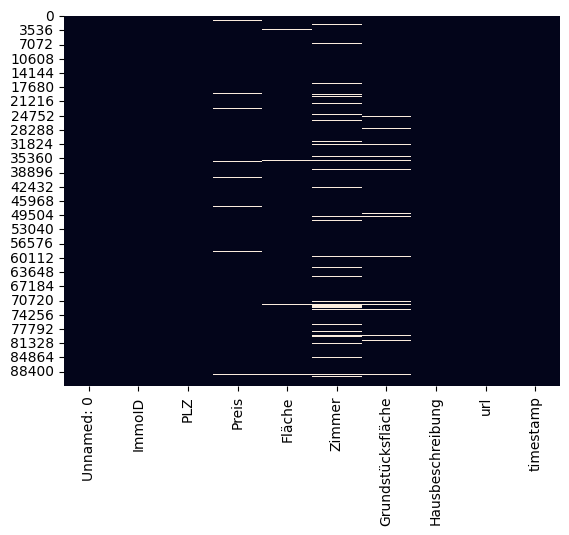

In [42]:
# Print a heatmap of missing values
sns.heatmap(Immos.isnull(), cbar=False)

## Combine Real-Estate-Data with Geographical Data
We want to create a map of the real estate data. To do this, we need to connect our data with geographical data (polygons).\
We already have the postal code (PLZ) that somehow does this already, but we have so many postal codes, that we could not read our map anymore.\
We therefore opted for districs (Landkreise) as a coarser resolution. For the scraping, we already used data for postal codes and\
fortunately, there is also information about the districts and we can merge the postal code data with our data.
### Check if District Codes are present in all the Data
For the map in our Dashboard, we also need polygons of the districts. We also have to check, if all district codes of our postal code dataset\
are also present in the geographical dataset of polygons.

In [43]:
# Read postal code data, turn it into a string and append leading 0.
Postleitzahlen = pd.read_csv("PLZ_Germany.csv", sep=";")
Postleitzahlen["Kreis code"] = Postleitzahlen["Kreis code"].astype(str)
Postleitzahlen["Kreis code"] = Postleitzahlen["Kreis code"].apply(lambda x: x.zfill(5))     # Put 0 in front of all 4 digit Kreis codes
print(f'Number of Districts in Postleitzahlen: {Postleitzahlen["Kreis code"].nunique()}')   # Print the number of district codes in this dataset

# Load the geographical data (shapefile).
shp_file = gpd.read_file("vg2500/VG2500_KRS.shp")
print(f'Number of Regions in Shapefile: {shp_file["ARS"].nunique()}')   # Print the number of district codes in this dataset

# Now look if there are district codes that are not in both datasets
print(Postleitzahlen[~Postleitzahlen["Kreis code"].isin(shp_file["ARS"])])

# We can see, that the code "16056" is not in our geographical dataset. This is an old code and it can be converted to "16063"
Postleitzahlen.loc[Postleitzahlen["Kreis code"] == "16056", "Kreis code"] = "16063"   # kreisfreie Stadt Eisenach is now part of Wartburgkreis

Number of Districts in Postleitzahlen: 401
Number of Regions in Shapefile: 400
       Name PLZ Name (short) PLZ Name (long)  \
6222  99817         Eisenach  99817 Eisenach   

                                               Geometry  \
6222  {"coordinates": [[[10.1757224, 50.9892372], [1...   

      Postleitzahl / Post code Kreis code  Land name  Land code  \
6222                     99817      16056  Thüringen         16   

                     Kreis name                  geo_point_2d  
6222  Kreisfreie Stadt Eisenach  50.9896307675, 10.3001203675  


### Merge Real-Estate-Data with Postal Code Data
We can now merge our real estate data with district data.\
We are merging these two datasets using the postal code. One problem is, that postal codes can be in multiple districts.\
We could assign them to only one postal code but I think the better option is to just duplicate these few houses.

In [45]:
# Merge our real estate dataset with postal code data
ImmoMerged = pd.merge(Immos, 
                      Postleitzahlen[["Postleitzahl / Post code", "Kreis code", "Kreis name"]].drop_duplicates(),   # There are some duplicates, drop them
                      left_on = "PLZ", 
                      right_on = "Postleitzahl / Post code")

# Print number of rows in our dataset before and after merging
print(f'Length of Data before merging: {len(Immos)}')
print(f'Length of Data after merging: {len(ImmoMerged)}')

# Save merged data
ImmoMerged[["Preis", "Fläche", "Zimmer", "Grundstücksfläche", "Kreis code", "Kreis name"]].to_csv("ImmoMerged.csv", index=False, header = True)

Length of Data before merging: 91921
Length of Data after merging: 94334


### Calculate Real-Estate Parameters
In our map, we want to display some key parameters for each district (e.g. mean price, mean number of rooms, ...).\
To do this, we use our merged data and from there on, calculate all key parameters for each district.

In [46]:
# Calculate, for each house, price per m² and m² per room
ImmoMerged["Preis_m2"] = ImmoMerged["Preis"] / ImmoMerged["Fläche"]
ImmoMerged["m2_Zimmer"] = ImmoMerged["Fläche"] / ImmoMerged["Zimmer"]

# Create an empty dictionary with all key parameters.
ImmoMeans = {"ARS": [], "KreisName": [], "MeanPreis": [], "MeanFläche": [], "MeanZimmer": [],
             "MeanGrundstücksfläche": [], "nHäuser": [], "MeanPreis_m2": [],
             "Meanm2_Zimmer": [], "VarPreis_m2": [], "VarProzentPreis_m2": []}

# For each district, calculate key parameters and append them to lists in the previously created dictionary
# (We use the median, which is more robust against outliers than the mean)
for LK in ImmoMerged["Kreis code"].unique():
    Immo_LK = ImmoMerged[ImmoMerged["Kreis code"]== LK]         # Only use data from the current district
    ImmoMeans["ARS"].append(LK)                                                         # District code
    ImmoMeans["KreisName"].append(Immo_LK["Kreis name"].unique()[0])                    # District name
    ImmoMeans["MeanPreis"].append(Immo_LK["Preis"].median())                            # Mean house price
    ImmoMeans["MeanFläche"].append(Immo_LK["Fläche"].median())                          # Mean house area
    ImmoMeans["MeanZimmer"].append(Immo_LK["Zimmer"].median())                          # Mean number of rooms
    ImmoMeans["MeanGrundstücksfläche"].append(Immo_LK["Grundstücksfläche"].median())    # Mean property area 
    ImmoMeans["nHäuser"].append(len(Immo_LK))                                           # Number of houses for sale in a district
    ImmoMeans["MeanPreis_m2"].append(Immo_LK["Preis_m2"].median())                      # Mean price per m²
    ImmoMeans["Meanm2_Zimmer"].append(Immo_LK["m2_Zimmer"].median())                    # Mean m² per room
    ImmoMeans["VarPreis_m2"].append(Immo_LK["Preis_m2"].std())                          # Variance (standard deviation) of price per m²
    ImmoMeans["VarProzentPreis_m2"].append(Immo_LK["Preis_m2"].std() / Immo_LK["Preis_m2"].mean())  # Variance (standard deviation) of price per m² relative to price (coefficient of variance)

# Save the district parameters
ImmoMeansDF = pd.DataFrame(ImmoMeans)
ImmoMeansDF = pd.DataFrame.from_dict(ImmoMeans)
ImmoMeansDF.to_csv("ImmoNumbers.csv", index=False, header = True)


### Geographical Data: Convert UTM-Coordinates into Web Mercator-Coordinates
There are many different coordinate systems. Geographical data of districts was obtained from an [official state website](https://gdz.bkg.bund.de/index.php/default/digitale-geodaten/verwaltungsgebiete/verwaltungsgebiete-1-2-500-000-stand-31-12-vg2500-12-31.html).\
Coordinates of that data were in the UTM-coordinate system. For a Map in a Dashboard, we need coordinates in a Web Mercator format. We use the module "utm" to convert them.\
Also, dash needs a geojson format as input. The geopandas module can take care of that.\
To plot districts on a map, we not only need coordinates but also their order. Therefore, coordinates are saved as Polygons (or MultiPolygons, if a district is split into e.g. islands).\
This type of data can be handled by shapely.geometry.

In [47]:
# These two websites substentially influences this script:
# https://stackoverflow.com/questions/20474549/extract-points-coordinates-from-a-polygon-in-shapely
# https://gis.stackexchange.com/questions/413420/converting-utm-to-lat-long-with-pythons-utm

# Load geographical data (shapefile) of districts (this is a pandas DataFrame!)
shp_file = gpd.read_file("C:/0_Entwicklung/Arbeitsverzeichnis/Python/vg2500/VG2500_KRS.shp")

# Set two parameters to convert coordinates
utm_zone = 32
utm_hemisphere = "N"

# Create an empty list to store all coordinates in
all_Polys = []

# Iterate through all districts
for LKi in range(len(shp_file)):

    # Get coordinates of one district. They are saved as Polygon or MultiPolygon
    poli = shp_file.loc[LKi, "geometry"]

    if poli.geom_type == "MultiPolygon":    # If the type is MultiPolygon:
        Multis = []                         # Create an empty list for all Polygons
        for Polyi in poli.geoms:            # For each Polygon, in a MuliPolygon...
            xx, yy = Polyi.exterior.coords.xy
            
            x = xx.tolist()                 # ... save x and y coordinates to a list 
            y = yy.tolist()
            
            newx = []
            newy = []
            newcoords = []
            
            for xi, yi in zip(x, y):        # Then, convert coordinates and save them in lists
                newyi, newxi = utm.to_latlon(xi, yi, utm_zone, utm_hemisphere)
                newx.append(newxi)
                newy.append(newyi)
                newcoords.append((newxi, newyi))    
            Multis.append(Polygon(newcoords))
        newpoly = MultiPolygon(Multis)

    else:                                   # If the type is a Polygon:
        xx, yy = poli.exterior.coords.xy    # Save x and y coordinates

        x = xx.tolist()
        y = yy.tolist()

        newx = []
        newy = []
        newcoords = []
        
        for xi, yi in zip(x, y):            # Convert coordinates
            newyi, newxi = utm.to_latlon(xi, yi, utm_zone, utm_hemisphere)
            newx.append(newxi)
            newy.append(newyi)
            newcoords.append((newxi, newyi))
        newpoly = Polygon(newcoords)
    all_Polys.append(newpoly)               # Add the current district Polygon or MultiPolygon to our Polygon list.

shp_file["geometry"] = all_Polys            # Replace old coordinates with the new ones.
shp_file.to_file("Landkreise_Mer.geojson", driver="GeoJSON")    # Save the data to a geojson-file

---
# 3. Plot Data
We can finally plot our data! We chose the dash library because it's a powerful and interactive tool for data visualization.\
The main aspect of the plot is a map that shows key parameters for each district (e.g. mean price per m²).\
Here, we can see where houses are especially expansive and where you get a large property with your house.\
To complement the map, we show the distribution of the key parameters as violin plots.\
You will see the distribution of all districts combined and if you click on a district, you will also see district data\
so you can compare this district to all other districts.

In [57]:
# Start the dash app:
app = dash.Dash(__name__)

# Load GeoJSON data
with open('C:/0_Entwicklung/Arbeitsverzeichnis/Python/Landkreise_Mer.geojson') as f:
    geojson_data = json.load(f)

# Load District data and add leading 0s to district code
ImmoNumbers = pd.read_csv('C:/0_Entwicklung/Arbeitsverzeichnis/Python/ImmoNumbers.csv')
ImmoNumbers["ARS"] = ImmoNumbers["ARS"].astype(str)
ImmoNumbers["ARS"] = ImmoNumbers["ARS"].apply(lambda x: x.zfill(5))

# Load data of all houses and add leading 0s to district code
Kreis_Immos = pd.read_csv("ImmoMerged.csv")
Kreis_Immos["Preis_m2"] = Kreis_Immos["Preis"] / Kreis_Immos["Fläche"]
Kreis_Immos["m2_Zimmer"] = Kreis_Immos["Fläche"] / Kreis_Immos["Zimmer"]
Kreis_Immos["Kreis code"] = Kreis_Immos["Kreis code"].astype(str)
Kreis_Immos["Kreis code"] = Kreis_Immos["Kreis code"].apply(lambda x: x.zfill(5))

# Add names and descriptions of key parameters (e.g. mean price)
VarDescription = {"Preis": "Durchschnittlicher Hauspreis im LK", "Durchschnittliche qm": "Durchschnittliche m²-Anzahl von Häuser im LK", 
                  "Anzahl Zimmer": "Durchschnittliche Anzahl der Zimmer pro Haus im LK", "Grundstücksfläche": "Durchschnittliche Grundstücksfläche, die zum Haus gehört", 
                  "Preis pro qm": "Durchschnittlicher Preis pro m²", "Anzahl Häuser": "Anzahl der Häuser, die im LK zum Verkauf stehen", 
                  "durchschnittliche Zimmergröße": "Durchschnittliche Größe der Zimmer (m²) im LK", "Preisvaribilität": "Variabilität der Preise im LK", 
                  "Prozentuale Preisvariabilität": "Variabilität der Preise im LK im Vergleich zum Hauspreis"}

# Create Divs for descriptions of key parameters
Description_Elements = []
for var_name, var_desc in VarDescription.items():
    Description_Elements.append(
        html.Div([

            # Key Parameter
            html.H4(var_name, style={"display": "inline-block", "width": "40%", "margin-top": "0", "margin-bottom": "0"}),

            # Key Parameter Description
            html.P(var_desc, style={"display": "inline-block", "width": "60%", "margin-top": "0", "margin-bottom": "0"})
        ], style={"margin-bottom": "5px"})
    )

'''===============================================================================================================================================================================================================================
                Start App Layout
==============================================================================================================================================================================================================================='''
app.layout = html.Div([
    
    # Title of Plot
    html.Div([  
        html.Label(["Willst du dir ein Haus kaufen?"], style={"font-weight": "bold", "font-size": "50px", "text-align": "left", "padding-left": "20px"}),
    ]),

    html.Div([

        # Plot description
        html.Div([
            html.P(["Hier kannst du dir anschauen, wie viele Häuser in deinem Landkreis zu verkaufen sind und was diese kosten sollen.", html.Br(),
                    "Du kannst deinen Landkreis außerdem mit anderen Landkreisen vergleichen.", html.Br()," Schau dir auf der Karte an, in welchem Landkreis " + 
                    "Häuser am meisten kosten, wie die Preise variieren", html.Br(),"und wo du die größten Grundstücke zu deinem Haus bekommst."], 
                    style={"font-size": "16px", "line-height": "20px", "text-align": "left", "padding-right": "100px"}),
        ], style = {"padding-left": "40px", "display": "inline-block", "width": "50%", 'verticalAlign': 'top'}),

        # Dropdown for key parameters
        html.Div([

            # Dropdown
            html.Div([
                html.Label(["Was willst du auf der Karte sehen?"], style={"font-weight": "bold", "text-align": "left"}),  # Label the dropdown
                dcc.Dropdown(id = "dd_data",
                            options = [{"label": x, "value": x} for x, y in VarDescription.items()], # options of the dropdown
                            value = "Preis",                    # Set a default value at the beginning
                            multi = False,                      # only allow for one choice
                            searchable = True,                  # you can search for key parameters in the dropdown
                            placeholder = "Wähle Merkmal",      # Define a placeholder, if nothing is selected.
                            className = "form-dropdown",        # CSS stuff
                            style = {"width": "90%"})           # use only 90% of width
            ], style = {"width": "50%", "margin-bottom": "20px"}),  
            
            # Key parameter description
            html.Div(
                Description_Elements
            ),
        ], style = {"width": "40%", "display": "inline-block", "padding-left": "10px"}),
        html.Hr(),  # Place horizontal line between Dropdowns and Plots
    ]),

    # Plots
    html.Div([

        # Violin Plot
        html.Div([
            dcc.Graph(id = "violin_plot",
                      style = {"flex-grow": 1})
        ], style = {"width": "50%", "display": "inline-block", "justify-content": "center", 
                    "flex-direction": "column", 'margin': 'auto', 'text-align': 'center'}),
        
        # Choropleth Map
        html.Div([
            dcc.Graph(id = "map_plot",
                      style = {"flex-grow": 1})
        ], style = {"width": "50%", "display": "inline-block", "flex-direction": "column", 
                    'margin': 'auto', 'text-align': 'center'})
    ], style = {"justify-content": "center"}),
    html.Hr(),

    # Violin Description Title
    html.Label(["Was ist das für eine Grafik?"],
               style={"font-weight": "bold", "font-size": "20px", "line-height": "20px", 
                      "text-align": "left", "padding-left": "40px"}),
    
    # Violin Description
    html.Div([
        
        # Violin Image
        html.Div([
            html.Img(src = "assets/ViolinPlot_explained.png", alt = "image", style = {"width": "100%"})
        ], style = {"width": "30%", "display": "inline-block", "padding-left": "30px"}),
        
        # Description Text
        html.Div([
            html.P(["Hier kannst du schauen, wie sich dein ausgewählter Landkreis im Vergleich zu den anderen Landkreisen schlägt.", html.Br(),
                        "Um einen Landkreis auszuwählen, klicke auf die Karte.", html.Br(),
                        "In der Grafik kannst du mehrere 'Violinen' erkennen. Schauen wir uns beispielsweise die Hauspreise an.", html.Br(), 
                        "In manchen Landkreisen werden mehr Häuser teurer verkauft als anderswo. Die breiteste Stelle der Violine zeigt, in welchem Preisbereich die meisten Häuser angeboten werden.", html.Br(),
                        "An den schmalen Stellen werden nur wenige Häuser im Preissegment verkauft.", html.Br(),
                        "Wir können hier erkennen, dass in den meisten Landkreisen Häuser in einem mittleren Preissegment angeboten werden und nur in manchen Landkreisen der Preis deutlich über dem Durchschnitt liegt.", html.Br(),
                        "Die Violine beschreibt also die Verteilung der Hauspreise. Jeder Punkt neben der Violine stellt einen Landkreis dar.", html.Br(),
                        "Jeder Punkt auf der linken Seite zeigt den mittleren Hauspreis eines Landkreises. Jeder Punkt auf der rechten Seite ist genau ein Haus.", html.Br(),
                        html.Br(),
                        "(Manchmal sind einzelne Häuser in einem Landkreis so teuer, dass die Violinen etwas 'zusammengequetscht' werden)"], 
                        style={"text-align": "left", "line-height": "20px"})
        ], style = {"width": "60%", "display": "inline-block", 'verticalAlign': 'top', "padding-left": "30px"})
    ])
], style = {"backgroundColor": "#FFFFFF"})


'''===============================================================================================================================================================================================================================
                Start App Callback
==============================================================================================================================================================================================================================='''

# Map Callback
@app.callback(
    Output("map_plot", "figure"),
    [Input("dd_data", "value")]
)
def build_map_graph(dd_data):

    # Key Parameter Name and Name in DataFrane
    immo_variable = {"Preis": "MeanPreis", 
                     "Durchschnittliche qm": "MeanFläche", 
                     "Anzahl Zimmer": "MeanZimmer", 
                     "Grundstücksfläche": "MeanGrundstücksfläche", 
                     "Preis pro qm": "MeanPreis_m2", 
                     "Anzahl Häuser": "nHäuser", 
                     "durchschnittliche Zimmergröße": "Meanm2_Zimmer", 
                     "Preisvaribilität": "VarPreis_m2",
                     "Prozentuale Preisvariabilität": "VarProzentPreis_m2"}[dd_data]

    # Create Choropleth Map
    fig = px.choropleth(
        ImmoNumbers,                        # DataFrame for Plotting
        geojson = geojson_data,             # GeoData
        locations = "ARS",                  # Location Key in DataFrame
        featureidkey = "properties.ARS",    # Location Key in GeoData
        color = immo_variable,              # Column of Data that determines colors
        color_continuous_scale="Viridis",   # Color Scale
        scope="europe",                     
        hover_name="KreisName",             # What do you see when hovering over a district?
        hover_data={immo_variable: True, "ARS": False}, # You don't see the district code
        labels={immo_variable: dd_data},    # The label of the value that you see for hovering is the key parameter name
        custom_data = ["ARS"]               # Variable, that is used by the violin plot
    )
    fig.update_geos(fitbounds = "locations", visible = False)   # Zoom to the stuff that you can see and don't show other country lines

    fig.update_layout(margin={"l": 0, "r": 0, "t": 0, "b": 0})  # Change margin of plot
    return fig

# Violin Callback
@app.callback(
    Output("violin_plot", "figure"),
    Input('map_plot', 'clickData')      # Input is what we specified as "custom_data" in the Map
)
def build_violins(clickData):

    # If you did not click on any district, use some default district, else, use the district, that was just clicked on the Map
    if not clickData:
        MapKreisName = "01054"
    else:
        MapKreisName = clickData["points"][0]["customdata"][0]

    # Extract data of all houses for the chosen district
    Kreisi = Kreis_Immos.loc[Kreis_Immos["Kreis code"] == MapKreisName]
    
    # Create a dictionary to build violin plots. All info that is needed to create the violins is in here.
    MetaDict = {
        
        # Column Names of key parameters in district data
        "ColumnIN": ["MeanPreis", "MeanFläche", "MeanZimmer",
                "MeanGrundstücksfläche", "nHäuser", "MeanPreis_m2",
                "Meanm2_Zimmer", "VarPreis_m2", "VarProzentPreis_m2"],

        # Key parameters of all Houses in the chosen district
        "DataKI": [Kreisi["Preis"], 
                Kreisi["Fläche"],
                Kreisi["Zimmer"],
                Kreisi["Grundstücksfläche"],
                np.array([len(Kreisi)]),    # this creates an array with one value and thus, no violin but only a line
                Kreisi["Preis_m2"],
                Kreisi["m2_Zimmer"],
                np.array([Kreisi["Preis_m2"].std()]),
                np.array([Kreisi["Preis_m2"].std() / Kreisi["Preis_m2"].mean()])],
        
        # Max values of key parameters to scale all violins between 0 and 1
        "Max": [max([max(ImmoNumbers["MeanPreis"]), np.nanmax(Kreisi["Preis"])]),
                max([max(ImmoNumbers["MeanFläche"]), np.nanmax(Kreisi["Fläche"])]),
                max([max(ImmoNumbers["MeanZimmer"]), np.nanmax(Kreisi["Zimmer"])]),
                max([max(ImmoNumbers["MeanGrundstücksfläche"]), np.nanmax(Kreisi["Grundstücksfläche"])]),
                max(ImmoNumbers["nHäuser"]),
                max([max(ImmoNumbers["MeanPreis_m2"]), np.nanmax(Kreisi["Preis_m2"])]),
                max([max(ImmoNumbers["Meanm2_Zimmer"]), np.nanmax(Kreisi["m2_Zimmer"])]),
                max(ImmoNumbers["VarPreis_m2"]),
                max(ImmoNumbers["VarProzentPreis_m2"])],
        
        # Key parameter names as x-axis labels (for violins containing all districts)
        "VarNamesIN": [np.repeat("Preis", len(ImmoNumbers)), 
                    np.repeat("Durchschnittliche qm", len(ImmoNumbers)),
                    np.repeat("Anzahl Zimmer", len(ImmoNumbers)),
                    np.repeat("Grundstücksfläche", len(ImmoNumbers)),
                    np.repeat("Anzahl Häuser", len(ImmoNumbers)),
                    np.repeat("Preis pro qm", len(ImmoNumbers)),
                    np.repeat("durchschnittliche Zimmergröße", len(ImmoNumbers)),
                    np.repeat("Preisvaribilität", len(ImmoNumbers)),
                    np.repeat("Prozentuale Preisvariabilität", len(ImmoNumbers))],
        
        # Key parameter names as x-axis labels (for violins containing houses of the chosen district)
        "VarNamesKI": [np.repeat("Preis", len(Kreisi)), 
                    np.repeat("Durchschnittliche qm", len(Kreisi)),
                    np.repeat("Anzahl Zimmer", len(Kreisi)),
                    np.repeat("Grundstücksfläche", len(Kreisi)),
                    ["Anzahl Häuser"],
                    np.repeat("Preis pro qm", len(Kreisi)),
                    np.repeat("durchschnittliche Zimmergröße", len(Kreisi)),
                    ["Preisvaribilität"],
                    ["Prozentuale Preisvariabilität"]],
        
        # Should the legend be plottet (only for first violin-plot)
        "Legend": [True, False, False, False, False, False, False, False, False],
        
        # Name of the district
        "KreisName": Kreisi["Kreis name"].unique()[0]
    }

    # Width of Violins
    V_width = 0.3

    # Start Violon Plot
    fig = go.Figure()

    # For each key parameter...
    for violini in range(len(MetaDict["ColumnIN"])):

        # Plot half a violin on the left side, that contains data of all districts
        fig.add_trace(
            go.Violin(x = MetaDict["VarNamesIN"][violini],                                              # x = Key Parameter
                      y = ImmoNumbers[MetaDict["ColumnIN"][violini]] / MetaDict["Max"][violini],        # y = Values of each District
                      side = "negative",                                                                # Plot Violin on left side
                      line_color = '#351c75',                                                           # Color of Violin
                      showlegend = MetaDict["Legend"][violini],                                         # Show only Legend of first Violin
                      legendgroup = 'Alle Kreise', scalegroup = 'Alle Kreise', name = 'Alle Kreise',    # Add Legend Label
                      pointpos = -1.5,                                                                  # Change Point Position
                      width = V_width)                                                                  # Define Width of Violin
        )

        # Plot half a violin on the right side, that contains data of all houses of the chosen district
        fig.add_trace(
            go.Violin(x = MetaDict["VarNamesKI"][violini],                                              # x = Key Parameter
                      y = MetaDict["DataKI"][violini] / MetaDict["Max"][violini],                       # y = Values of each House in the chosen district
                      side = "positive",                                                                # Plot Violin on right side
                      line_color = '#6aa84f',                                                           # Color of Violin
                      showlegend = MetaDict["Legend"][violini],                                         # Show only Legend of first Violin
                      legendgroup = 'Kreisi', scalegroup = 'Kreisi', name = MetaDict["KreisName"],      # Add Legend Label
                      pointpos = 1.5,                                                                   # Change Point Position
                      width = V_width)                                                                  # Define Width of Violin
        )

    # Add points, Meanline 
    fig.update_traces(meanline_visible = True,  # Line at Mean is visible
                      points = 'all',           # Plot all Points and not just Outlier
                      jitter = 0.05,            # Jitter of Points
                      scalemode = 'width')      # Scale Violin Plot Area with Total Count
    
    # Update Plot Layout
    fig.update_layout(
        violingap = 0, violingroupgap = 0, violinmode = 'overlay',
        legend = {"orientation": "h", "yanchor": "bottom", "y": 1.02},
        yaxis = {"showticklabels": False})
    
    return fig


# Run the App!
if __name__ == '__main__':
    app.run_server(debug=True, port = 8060, host = "127.0.0.1")

### Violin Plots are really complicated!
That's why I decided to explain them a little. I therefore created a plot of only one Violin and then added some explanation with Powerpoint.\
This is just the code to make the base plot:
```python
Kreisi = Kreis_Immos.loc[Kreis_Immos["Kreis code"] == Kreis_Immos["Kreis code"].unique()[0]]
MetaDict = {
    "ColumnIN": ["MeanPreis", "MeanFläche", "MeanZimmer",
            "MeanGrundstücksfläche", "nHäuser", "MeanPreis_m2",
            "Meanm2_Zimmer", "VarPreis_m2", "VarProzentPreis_m2"],
    "ColumnKI": ["Preis", "Fläche", "Zimmer", "Grundstücksfläche"],
    "DataKI": [Kreisi["Preis"], 
            Kreisi["Fläche"],
            Kreisi["Zimmer"],
            Kreisi["Grundstücksfläche"],
            np.array([len(Kreisi)]),
            Kreisi["Preis_m2"],
            Kreisi["m2_Zimmer"],
            np.array([Kreisi["Preis_m2"].std()]),
            np.array([Kreisi["Preis_m2"].std() / Kreisi["Preis_m2"].mean()])],
    "Max": [max([max(ImmoNumbers["MeanPreis"]), np.nanmax(Kreisi["Preis"])]),
            max([max(ImmoNumbers["MeanFläche"]), np.nanmax(Kreisi["Fläche"])]),
            max([max(ImmoNumbers["MeanZimmer"]), np.nanmax(Kreisi["Zimmer"])]),
            max([max(ImmoNumbers["MeanGrundstücksfläche"]), np.nanmax(Kreisi["Grundstücksfläche"])]),
            max(ImmoNumbers["nHäuser"]),
            max([max(ImmoNumbers["MeanPreis_m2"]), np.nanmax(Kreisi["Preis_m2"])]),
            max([max(ImmoNumbers["Meanm2_Zimmer"]), np.nanmax(Kreisi["m2_Zimmer"])]),
            max(ImmoNumbers["VarPreis_m2"]),
            max(ImmoNumbers["VarProzentPreis_m2"])],
    "VarNamesIN": [np.repeat("Preis", len(ImmoNumbers)), 
                np.repeat("Durchschnittliche qm", len(ImmoNumbers)),
                np.repeat("Anzahl Zimmer", len(ImmoNumbers)),
                np.repeat("Grundstücksfläche", len(ImmoNumbers)),
                np.repeat("Anzahl Häuser", len(ImmoNumbers)),
                np.repeat("Preis pro qm", len(ImmoNumbers)),
                np.repeat("durchschnittliche Zimmergröße", len(ImmoNumbers)),
                np.repeat("Preisvaribilität", len(ImmoNumbers)),
                np.repeat("Prozentuale Preisvariabilität", len(ImmoNumbers))],
    "VarNamesKI": [np.repeat("Preis", len(Kreisi)), 
                np.repeat("Durchschnittliche qm", len(Kreisi)),
                np.repeat("Anzahl Zimmer", len(Kreisi)),
                np.repeat("Grundstücksfläche", len(Kreisi)),
                ["Anzahl Häuser"],
                np.repeat("Preis pro qm", len(Kreisi)),
                np.repeat("durchschnittliche Zimmergröße", len(Kreisi)),
                ["Preisvaribilität"],
                ["Prozentuale Preisvariabilität"]],
    "Legend": [True, False, False, False, False, False, False, False, False],
    "KreisName": Kreisi["Kreis name"].unique()[0]
}

V_width = 0.3

fig = go.Figure()


for violini in range(1):
    fig.add_trace(
        go.Violin(x = MetaDict["VarNamesIN"][violini], 
                    y = ImmoNumbers[MetaDict["ColumnIN"][violini]] / MetaDict["Max"][violini],
                    side = "negative",
                    line_color = '#351c75',
                    showlegend = MetaDict["Legend"][violini],
                    legendgroup = 'Alle Kreise', scalegroup = 'Alle Kreise', name = 'Alle Kreise',
                    pointpos = -1.5, 
                    width = V_width)
    )
    fig.add_trace(
        go.Violin(x = MetaDict["VarNamesKI"][violini], 
                    y = MetaDict["DataKI"][violini] / MetaDict["Max"][violini],
                    side = "positive",
                    line_color = '#6aa84f',
                    showlegend = MetaDict["Legend"][violini],
                    legendgroup = 'Kreisi', scalegroup = 'Kreisi', name = MetaDict["KreisName"],
                    pointpos = 1.5, 
                    width = V_width)
    )

fig.update_traces(meanline_visible = True,
                    points = 'all',
                    jitter = 0.05,
                    scalemode = 'width')
fig.update_layout(
    violingap = 0, violingroupgap = 0, violinmode = 'overlay',
    width = 300,
    height = 500,
    legend = {"orientation": "h", "yanchor": "bottom", "y": 1.02},
    yaxis = {"showticklabels": False})

fig.write_image("assets/ViolinPlot.png", format='png', engine='kaleido')
```